# Data of temperatures in Chile

Author: Hugo Carrillo

Creation: July 2024

This notebook shows the very beginning steps in heatwave detection from meteorological stations data. 
1. Detection of missing data: quantification and cleaning.
2. Selection of stations. 
3. We generate cleaned data for heatwave detections.

## Libraries import

In [1]:
import sys
import os

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import norm
from scipy.optimize import curve_fit

import pickle


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) # Suppress specific RuntimeWarnings

In [2]:
%load_ext autoreload
%autoreload 2

# Parameters


In [3]:
#INPUT_FOLDER_PATH =  'notebooks/hcarrillo/'
METADATA_PATH_AND_FILENAME = 'data/metadata.parquet'
TEMP_DATA_PATH = 'data/original/' #'../diagnosis/Central_Chile_data/'
CLEANED_DATA_PATH = 'data/cleaned/' #'../diagnosis/Central_Chile_data/'
MY_FUNCTIONS_PATH = 'functions/'


#os.chdir('../')

In [5]:
!pip install geopandas

     ---------------------------------------- 0.0/323.6 kB ? eta -:--:--
     ------------- ------------------------ 112.6/323.6 kB 6.4 MB/s eta 0:00:01
     -------------------------------------  317.4/323.6 kB 3.9 MB/s eta 0:00:01
     -------------------------------------- 323.6/323.6 kB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
     ---------------------------------------- 0.2/16.2 MB 5.6 MB/s eta 0:00:03
      --------------------------------------- 0.3/16.2 MB 3.9 MB/s eta 0:00:05
     - -------------------------------------- 0.7/16.2 MB 5.6 MB/s eta 0:00:03
     -- ------------------------------------- 1.1/16.2 MB 6.3 MB/s eta 0:00:03
     --- ------------------------------------ 1.4/16.2 MB 6.8 MB/s eta 0:00:03
     --- ------------------------------------ 1.4/16.2 MB 6.8 MB/s eta 0:00:03
     ---- ----------------------------------- 1.7/16.2 MB 5.8 MB/s eta 0:00:03
     ----- ---------------------------------- 2.1/16.2 MB 6.2 


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# Add the folder to the Python path
folder_path = os.path.abspath(MY_FUNCTIONS_PATH) #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

from HWFunctionsWithMaps import (
    map_stations,
    KoeppenMap,
    KoeppenMapWithStations
)
#from HWCompAndStats import HW_statistics
from HWCompAndStats import (
    model,
    model_fit,
    RSS,
    compute_quartiles,
    HW_indices_by_year,
    HW_indices_summary,
    get_trends,
    HW_stats_of_indices,
    plot_stats_of_hwi,
    plot_t_and_u_test_p_values, 
    HW_statistics, 
    HW_idx
)

# Utilities


In [8]:
# this function takes the hourly temperatures and defines the max, min, and mean temperatures.
def to_format(data):
    #data is a pd dataframe containing the hourly temperatures for a given station
    data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")
    data.index = data['date']#.dt.date

    max_temp = data.resample('D').max()
    #max_temp = data.resample('D').apply(lambda x: np.nanmax(x))
    max_temp.rename(columns={'temperature': 'max_temp'}, inplace=True)
    max_temp = max_temp.drop(columns=['date'])

    max_temp.index = pd.to_datetime(max_temp.index.date)


    min_temp = data.resample('D').min()
    min_temp.rename(columns={'temperature': 'min_temp'}, inplace=True)
    min_temp = min_temp.drop(columns=['date'])
    min_temp.index = pd.to_datetime(min_temp.index.date)


    mean_temp = data.resample('D').mean()
    mean_temp.rename(columns={'temperature': 'mean_temp'}, inplace=True)
    mean_temp = mean_temp.drop(columns=['date'])
    mean_temp.index = pd.to_datetime(mean_temp.index.date)


    #data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d").dt.tz_localize(None)#date
    #data.index = data['date'].dt.date

    #return pd.concat([max_temp, min_temp, mean_temp])
    return pd.concat([max_temp, min_temp, mean_temp], axis=1)

# Reading data

In [7]:
# get all meteochile stations information
stations = pd.read_parquet(METADATA_PATH_AND_FILENAME)
stations.head()

,WMO_code,ICAO_code,name,latitude,longitude,altitude,state_id,geographic_zone_id,data_link
national_code,,,,,,,,,
170001,85403,,Visviri Tenencia,-17.59500,-69.47750,4084,15,0,https://climatologia.meteochile.gob.cl/applica...
180005,85406,SCAR,"Chacalluta, Arica Ap.",-18.35555,-70.34028,50,15,1,https://climatologia.meteochile.gob.cl/applica...
180017,85405,,Putre,-18.20000,-69.56250,3532,15,2,https://climatologia.meteochile.gob.cl/applica...
180018,85407,,"Defensa Civil, Arica",-18.49111,-70.30139,71,15,1,https://climatologia.meteochile.gob.cl/applica...
180042,85408,,"Cerro Sombrero, Arica",-18.51250,-70.26556,122,15,1,https://climatologia.meteochile.gob.cl/applica...


In [12]:
# Reading raw data of selected stations
#statlist = [330007, 330020, 330030, 340031, 360011, 380013, 360019, 390006, 400009, 410005]
statlist = [330020]
station_data_to_read = {}
stations_data = {}
for stat in statlist:
    station_data_to_read[stat] = pd.read_parquet(TEMP_DATA_PATH + f'{stat}.parquet')
    station_data_to_read[stat] = station_data_to_read[stat][station_data_to_read[stat]['date'].dt.year > 1970]
    stations_data[stat] = to_format(station_data_to_read[stat])
    #save
    stations_data[stat].to_parquet(CLEANED_DATA_PATH + f'{stat}.parquet')



In [13]:
# checking the data
print('Temp data:')
print(station_data_to_read[stat].head())
print('-------')
print('-------')
print('Temp data in format:')
print(stations_data[stat].head())



Temp data:
                                               date  temperature
date                                                            
1971-01-01 09:00:00-03:00 1971-01-01 09:00:00-03:00         20.0
1971-01-01 15:00:00-03:00 1971-01-01 15:00:00-03:00         31.0
1971-01-01 21:00:00-03:00 1971-01-01 21:00:00-03:00         23.4
1971-01-02 09:00:00-03:00 1971-01-02 09:00:00-03:00         16.8
1971-01-02 21:00:00-03:00 1971-01-02 21:00:00-03:00         21.6
-------
-------
Temp data in format:
            max_temp  min_temp  mean_temp
1971-01-01      31.0      20.0  24.800000
1971-01-02      21.6      16.8  19.200000
1971-01-03      27.8      16.8  22.533333
1971-01-04      28.6      16.8  22.733333
1971-01-05      29.4      18.6  23.666667


In [14]:
# This cell provides information about the missing and possible cleaning of the data
# In the case of Chile, we found missing data in form of nans. See the table in the output cell.

df_nans = pd.DataFrame(index=statlist)
total_days = np.zeros((len(statlist),))
missing_days = np.zeros((len(statlist),))
missing_hours = np.zeros((len(statlist),))
total_hours = np.zeros((len(statlist),))
missing_daytime = np.zeros((len(statlist),))


for i, stat in enumerate(statlist):
    total_days[i] = len(station_data_to_read[stat].groupby(station_data_to_read[stat].index.date))

    days_with_nan = stations_data[stat].isna().groupby(stations_data[stat].index.date).any()
    nan_days = days_with_nan[days_with_nan['max_temp']].index

    missing_days[i] = len(nan_days)

    other_missings = stations_data[stat][stations_data[stat]['max_temp'] - stations_data[stat]['min_temp'] < 1e-5]
    missing_daytime[i] = len(other_missings)

    days_with_nan = station_data_to_read[stat].isna().groupby(station_data_to_read[stat].index.date).any()
    nan_days = days_with_nan[days_with_nan['temperature']].index
    df_with_nan_days = station_data_to_read[stat][np.isnan(station_data_to_read[stat]['temperature'])]
    missing_hours[i] = len(df_with_nan_days)
    total_hours[i] = len(station_data_to_read[stat])

    days_with_nan = stations_data[stat].isna().groupby(stations_data[stat].index.date).any()
    nan_days = days_with_nan[days_with_nan['max_temp']].index

df_nans['tot. days'] = total_days
df_nans['miss. days'] = missing_days
df_nans['p. miss. days'] = missing_days/total_days
df_nans['miss. hours'] = missing_hours
df_nans['p. miss. hours'] = missing_hours/total_hours
#df_nans['miss. daytime'] = missing_daytime

print(df_nans)

        tot. days  miss. days  p. miss. days  miss. hours  p. miss. hours
330020    19577.0         2.0       0.000102         13.0        0.000073


In [15]:
print(f"Percentage of missing entries={sum(df_nans['miss. hours'])/sum(total_hours)}")
print(f"Percentage of missing days={sum(df_nans['miss. days'])/sum(df_nans['tot. days'])}")

Percentage of missing entries=7.294232506466618e-05
Percentage of missing days=0.00010216069877917965


2
0.00010331645831180907


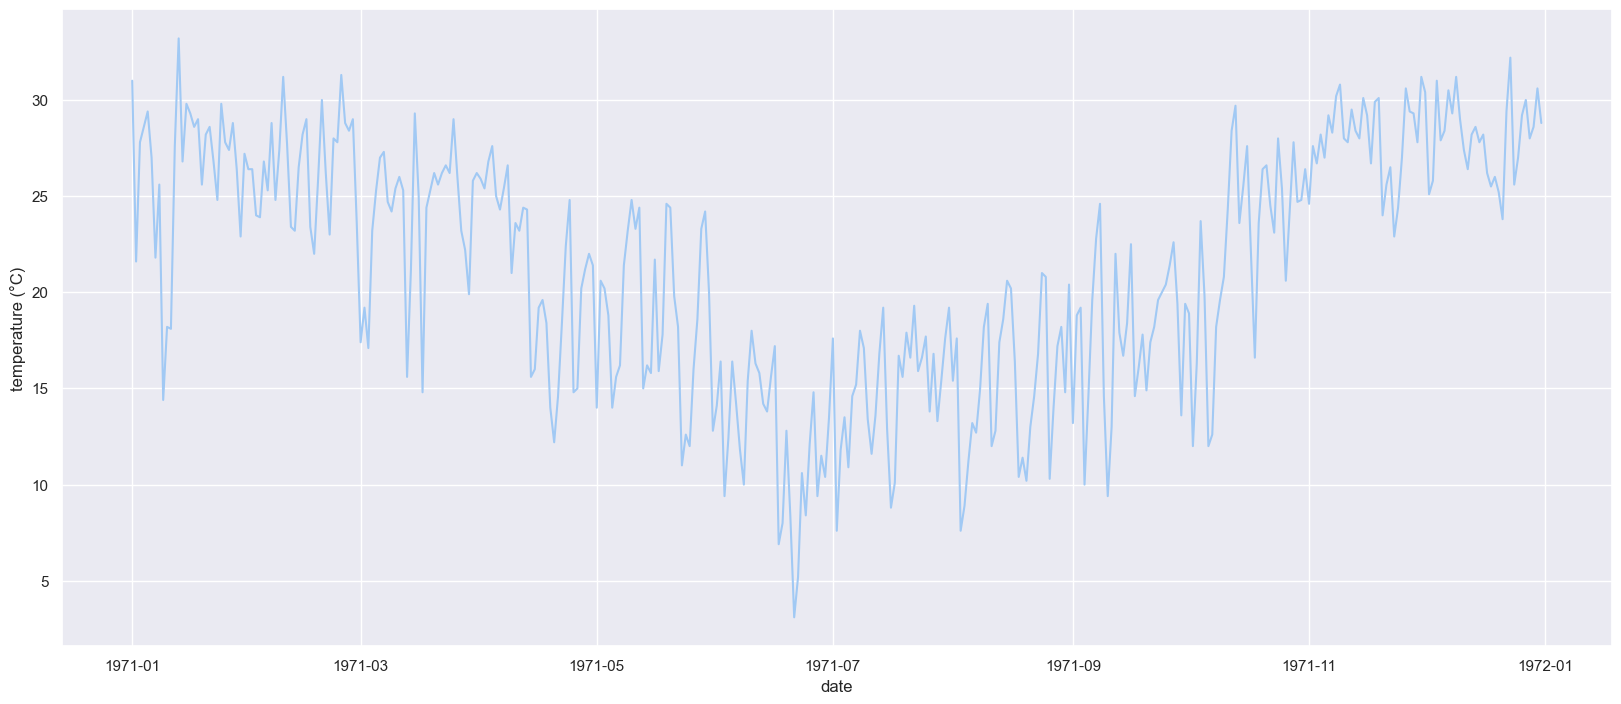

In [17]:
# Example of missing data
ii = 0
statlist[ii]

df_aux = stations_data[statlist[ii]]['max_temp'][stations_data[statlist[ii]].index.year > 1970]
df_aux = df_aux[df_aux.index.year < 2024]
plt.plot(df_aux[df_aux.index.year < 1972])# and stations_data[330030].index.year < 1972])
plt.xlabel('date')
plt.ylabel('temperature (°C)')

station_data_nans = df_aux[np.isnan(df_aux)]
#stations_data[statlist[ii]][np.isnan(stations_data[statlist[ii]]['mean_temp'])]
print(len(station_data_nans))
print(len(station_data_nans)/len(df_aux))